## Фреймворк PyTorch для разработки искусственных нейронных сетей

###Урок 10. Распознавание лиц и эмоций

**Задание**

Задание по итогам курса:
(упрощенное/для тех, у кого нет вебкамеры)

Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
(более сложное)

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.
В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab
У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

### Модуль 1 Препроцессинг

Установка библиотек

In [1]:
!pip install facenet-pytorch==2.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
# import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

In [3]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [02:08<00:00, 19.5MB/s]
100% 2.13G/2.13G [02:08<00:00, 17.8MB/s]


In [5]:
!unzip /content/leapgestrecog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [6]:
images = glob('leapGestRecog/**/**/*.png')

In [7]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['leapGestRecog/05/02_l/frame_05_02_0035.png',
  'leapGestRecog/05/02_l/frame_05_02_0126.png',
  'leapGestRecog/05/02_l/frame_05_02_0018.png'],
 [1, 1, 1],
 20000,
 20000)

In [8]:
num_name_list = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name
        
sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [9]:
def num_to_classname(num):
  
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [10]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

(240, 640)


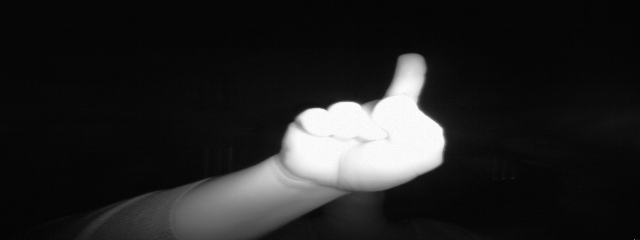

In [11]:
img = Image.open(images[1313])
print(np.array(img).shape)
img

In [12]:
# Transform train & test data

train_tfms = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1), # Картинки черно-белые - переводим чтобы была 1-канальность1
                         transforms.Resize((48,48)),
                         transforms.RandomHorizontalFlip(), # Случайные повороты на 90 градусов
                         transforms.RandomRotation(30), # Случайные повороты на 30 градусов
                         transforms.ToTensor()]) # Приведение к тензору
                         # это на обучение чтобы сделать побольше данный и аугмиентацию

test_tfms =  transforms.Compose([  
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста только перевод в чб и в тензор переводим

In [13]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):      
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx]) 
        img = self.transformer(img)
      
        return img, self.labels[idx]

In [14]:
batch_size = 256

# Create datasets
train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

Класс: 8 - c
torch.Size([1, 48, 48])


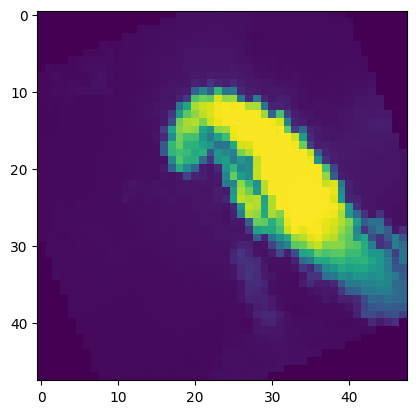

Класс: 2 - fist
torch.Size([1, 48, 48])


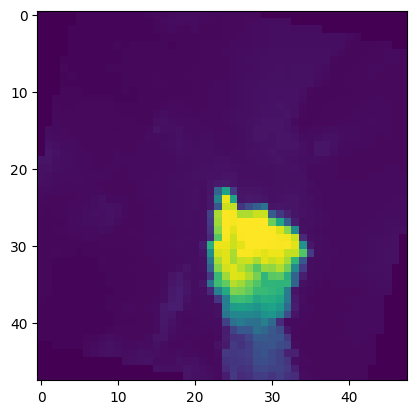

Класс: 2 - fist
torch.Size([1, 48, 48])


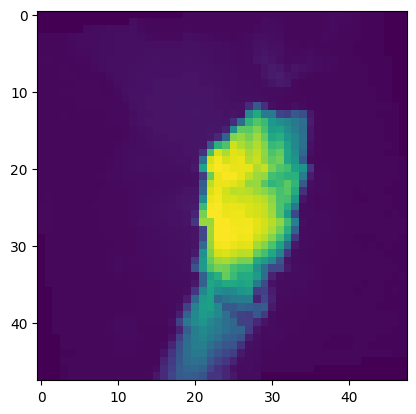

In [15]:
for i, data in enumerate(train_loader):
    print(f'Класс: {data[1][i]} - {num_to_classname(data[1][i])}')
    print(data[0][i].shape)
    plt.imshow(data[0][i].permute(1,2,0).squeeze())
    plt.show()
    if i==2:
        break

image: torch.Size([1, 48, 48])


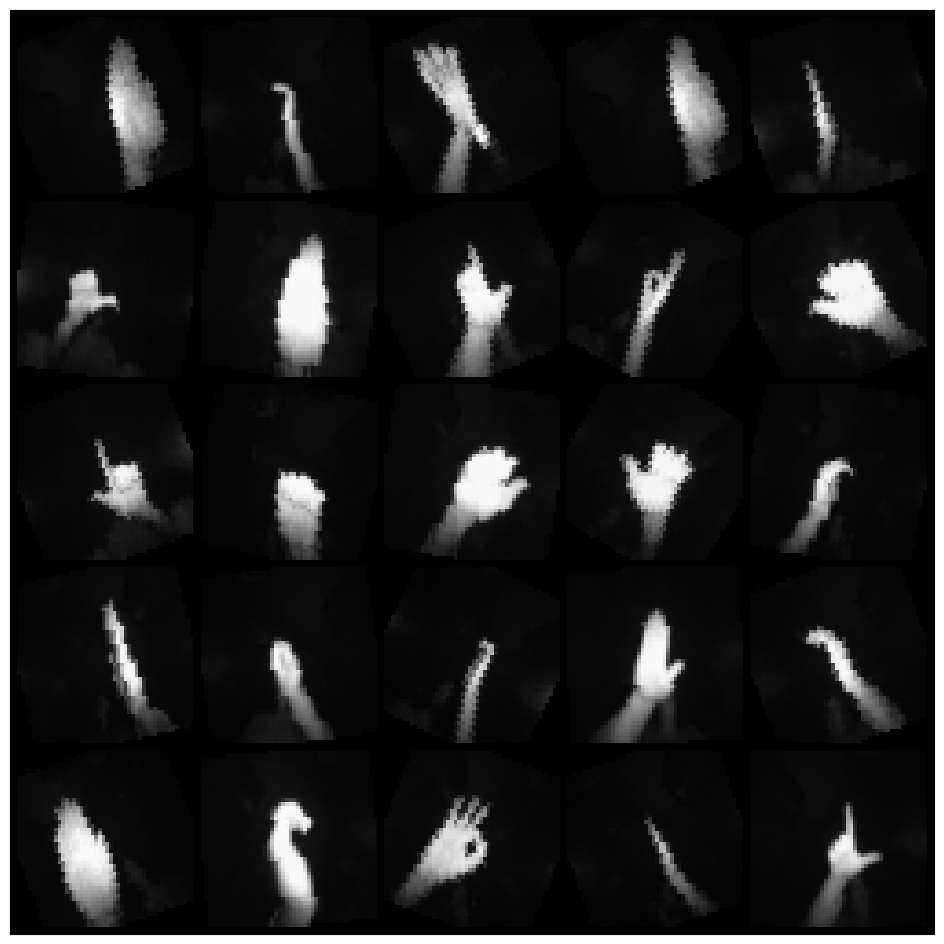

In [16]:
def show_batch(train_loader):
  
    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:25], nrow=5).permute(1, 2, 0))
        break

show_batch(train_loader) 

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [19]:
model = ResNet(1, len(num_name_dict)).to(device)

In [20]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [21]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

Real gesture: (0, 'palm'), Predicted gesture: (1, 'l')


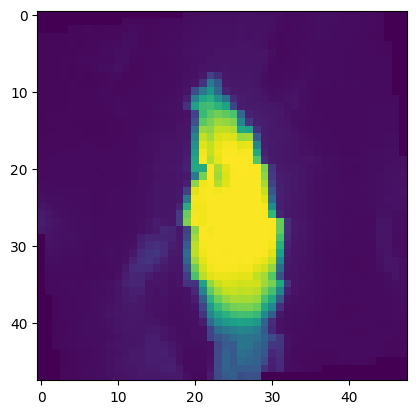

In [22]:
for i, (img, label) in enumerate(train_loader):
    output = model(img[i][None].to(device))
    print(f'Real gesture: {int(label[i]), num_to_classname(int(label[i]))}, '
          f'Predicted gesture: {int(output.argmax(1)), num_to_classname(int(output.argmax(1)))}')
    plt.imshow(img[i].permute(1,2,0).squeeze())
    break

In [23]:
epochs = 20

epoch_losses = []

for epoch in range(epochs):
    
    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        train_running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc
        
        loss.backward()
        optimizer.step()
        
        
    test_running_loss, total_acc_test = 0.0, 0.0
    test_epoch_loss = []
    for data, labels in test_loader:
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = criterion(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_test += acc
        
    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Test loss:, {np.mean(test_epoch_loss)}, Test acc: {total_acc_test / len(test_dataset):.3f}')
    epoch_losses.append(epoch_loss)

100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 1, loss:, 7.968499775590567, Train acc:, 0.150  Test loss:, 2.0521419525146483, Test acc: 0.249


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]


Epoch 2, loss:, 2.0380382928354988, Train acc:, 0.253  Test loss:, 1.8061071157455444, Test acc: 0.319


100%|██████████| 58/58 [00:40<00:00,  1.44it/s]


Epoch 3, loss:, 1.5545208125278867, Train acc:, 0.445  Test loss:, 1.2553709030151368, Test acc: 0.525


100%|██████████| 58/58 [00:40<00:00,  1.43it/s]


Epoch 4, loss:, 1.0276429622337735, Train acc:, 0.607  Test loss:, 0.694018229842186, Test acc: 0.740


100%|██████████| 58/58 [00:40<00:00,  1.43it/s]


Epoch 5, loss:, 0.6716211725925577, Train acc:, 0.737  Test loss:, 0.5443601056933403, Test acc: 0.805


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch 6, loss:, 0.5397245822281673, Train acc:, 0.790  Test loss:, 0.4508403867483139, Test acc: 0.834


100%|██████████| 58/58 [00:40<00:00,  1.43it/s]


Epoch 7, loss:, 0.44117022665410205, Train acc:, 0.827  Test loss:, 0.28811956122517585, Test acc: 0.899


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]


Epoch 8, loss:, 0.21768915614691273, Train acc:, 0.918  Test loss:, 0.10239851996302604, Test acc: 0.972


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch 9, loss:, 1.071871295956702, Train acc:, 0.795  Test loss:, 7.927629280090332, Test acc: 0.144


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch 10, loss:, 2.749870553098876, Train acc:, 0.177  Test loss:, 1.9266827166080476, Test acc: 0.301


100%|██████████| 58/58 [00:41<00:00,  1.41it/s]


Epoch 11, loss:, 1.6783020886881599, Train acc:, 0.402  Test loss:, 1.4345805108547212, Test acc: 0.477


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 12, loss:, 0.9293740412284588, Train acc:, 0.655  Test loss:, 0.5824771523475647, Test acc: 0.787


100%|██████████| 58/58 [00:40<00:00,  1.43it/s]


Epoch 13, loss:, 0.3996922890173978, Train acc:, 0.850  Test loss:, 0.24896638393402098, Test acc: 0.924


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]


Epoch 14, loss:, 0.16823359861456114, Train acc:, 0.933  Test loss:, 0.07701856661587954, Test acc: 0.976


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]


Epoch 15, loss:, 0.07181094609329412, Train acc:, 0.967  Test loss:, 0.0442706354893744, Test acc: 0.988


100%|██████████| 58/58 [00:40<00:00,  1.42it/s]


Epoch 16, loss:, 0.31539200644554766, Train acc:, 0.893  Test loss:, 0.05939350537955761, Test acc: 0.992


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 17, loss:, 0.050195541425511754, Train acc:, 0.977  Test loss:, 0.019277548673562704, Test acc: 0.996


100%|██████████| 58/58 [00:40<00:00,  1.43it/s]


Epoch 18, loss:, 0.027128268579213785, Train acc:, 0.982  Test loss:, 0.011836791341193021, Test acc: 0.998


100%|██████████| 58/58 [00:40<00:00,  1.44it/s]


Epoch 19, loss:, 0.02351258450251972, Train acc:, 0.984  Test loss:, 0.01083287987858057, Test acc: 0.998


100%|██████████| 58/58 [00:40<00:00,  1.44it/s]


Epoch 20, loss:, 0.013067088370885828, Train acc:, 0.987  Test loss:, 0.008215046278201044, Test acc: 0.999


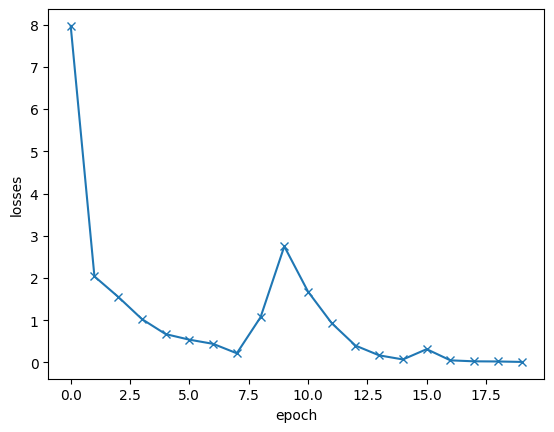

In [24]:
# Plot loss

losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [25]:
# Save model

model_path = './gesture_classification_model.pth'
torch.save(model, model_path)

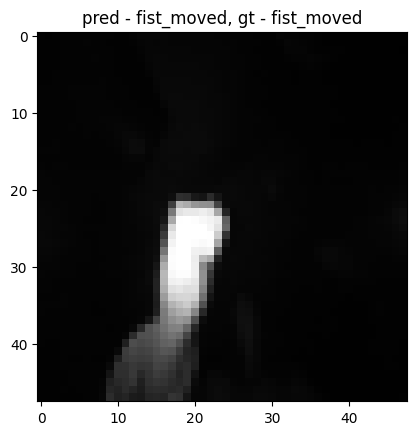

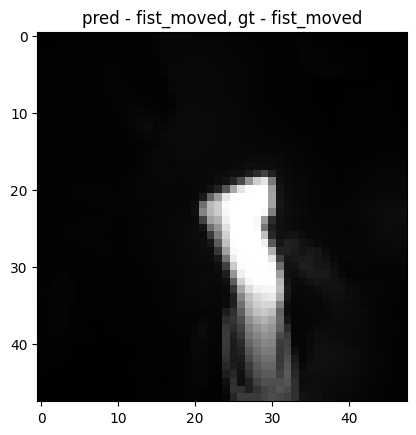

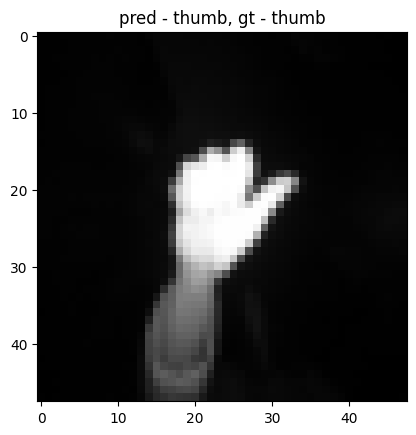

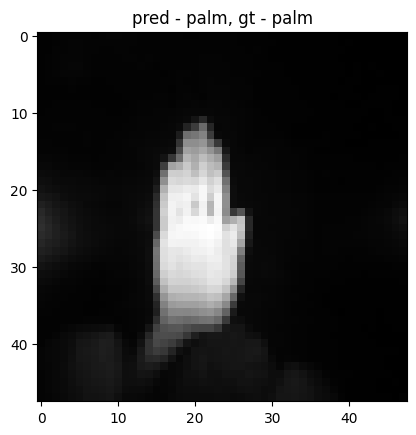

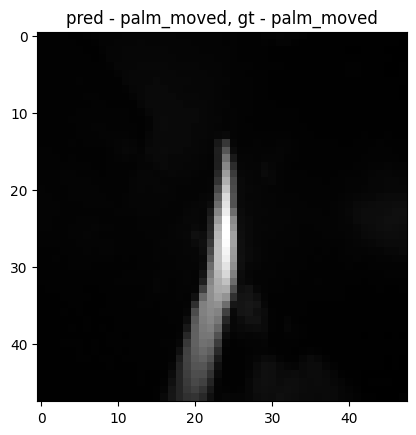

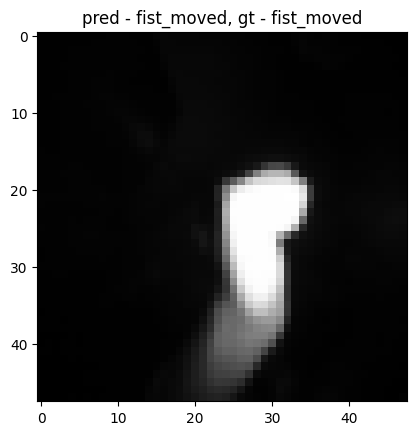

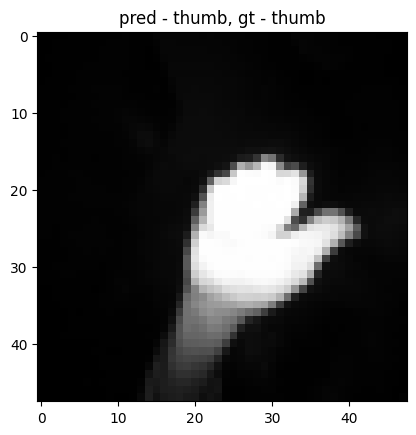

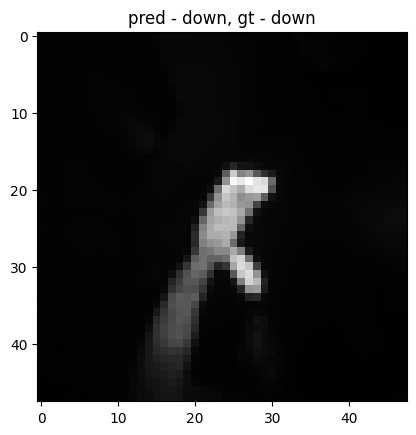

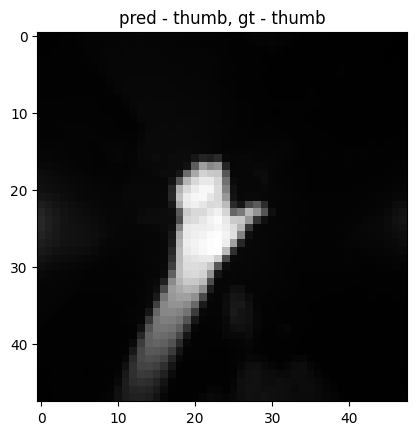

In [26]:
# Load model

model = torch.load(model_path)
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [27]:
# все сохранилось хорошо